In [ ]:
!git clone https://github.com/clinicalml/human_ai_deferral.git

Cloning into 'human_ai_deferral'...
remote: Enumerating objects: 191, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 191 (delta 46), reused 30 (delta 20), pack-reused 102
Receiving objects: 100% (191/191), 3.13 MiB | 8.31 MiB/s, done.
Resolving deltas: 100% (59/59), done.
Updating files: 100% (142/142), done.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/L2Dcode/

/content/drive/MyDrive/L2Dcode


In [3]:
!ls

baselines	   datasets.PNG       environment.yml  human_ai_deferral      networks
data		   defer_diagram.PNG  exp_data	       L2D_CIFARH_Demo.ipynb  README.md
datafixed_dataset  demo.ipynb	      experiments      lecture.ipynb	      trained
datasetsdefer	   docs		      helpers	       methods


In [4]:
import os
import pickle
import sys
import PIL

import torch
import torch.optim as optim
import torch.nn as nn

import datetime
import time
from matplotlib import pyplot as plt
from matplotlib import cm, colors
import numpy as np

# allow logging to print everything
import logging
logging.basicConfig(level=logging.DEBUG)
import warnings
warnings.filterwarnings('ignore')
import pickle

import torch.optim as optim
from baselines.compare_confidence import *
from baselines.differentiable_triage import *
from baselines.lce_surrogate import *
from baselines.mix_of_exps import *
from baselines.one_v_all import *
from baselines.selective_prediction import *
from datasetsdefer.broward import *
# from datasetsdefer.chestxray import *
from datasetsdefer.cifar_h import *
from datasetsdefer.cifar_synth import *
# from datasetsdefer.generic_dataset import *
# from datasetsdefer.hatespeech import *
from datasetsdefer.imagenet_16h import *
# from datasetsdefer.synthetic_data import *
# from datasetsdefer.synthetic_data import SyntheticData
# from methods.milpdefer import *
from methods.realizable_surrogate import *
from networks.cnn import *
from networks.cnn import DenseNet121_CE, NetSimple, WideResNet
from networks.linear_net import *
from helpers.metrics import *

## Setup
First we will setup up our working directory, explore our data and create some helpful functions to conduct some experiments.



In [ ]:
# Set-up folders
if not os.path.exists("./data"):
  os.makedirs("./data")

if not os.path.exists("./exp_data"):
  os.makedirs("./exp_data")
  os.makedirs("./exp_data/data")
  os.makedirs("./exp_data/plots")
  os.makedirs("./exp_data/models")
#path_model = '../exp_data/models/imagenet_16h_dn161_100epochs.pt'

In [5]:
# generate data for training, validation and test sets
data_dir = './data'
dataset = Cifar10h(False, data_dir = data_dir)
#filehandler = open(data_dir+'fixed_dataset', 'wb')
#pickle.dump(dataset, filehandler)
#filehandler.close()

Files already downloaded and verified


In [6]:
dataset = pickle.load(open(data_dir+'fixed_dataset', 'rb'))

We will work on a special version of the famous CIFAR10 dataset, called CIFAR10-H. This is an image dataset, with 10 different classes, and two labels per image: one label is the actual ground truth, on label is the label given by a human annotator.

In [7]:
cifar_map = {0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'
 }

Let us define a function to train a h

In [8]:
def get_image_info(i):
  exp = 'Human preds:'+str(dataset.data_train_loader.dataset.expert_preds[i])+' '+cifar_map[dataset.data_train_loader.dataset.expert_preds[i]]
  y = 'True label: '+str(dataset.data_train_loader.dataset.targets[i])+' '+cifar_map[dataset.data_train_loader.dataset.targets[i]]
  return y+'\n'+exp

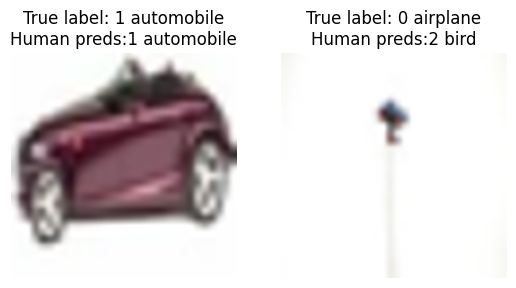

In [9]:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(PIL.Image.fromarray(dataset.data_train_loader.dataset.images[0]).resize((200,200)))
plt.axis('off')
plt.title(get_image_info(0))
f.add_subplot(1,2, 2)
plt.imshow(PIL.Image.fromarray(dataset.data_train_loader.dataset.images[2]).resize((200,200)))
plt.axis('off')
plt.title(get_image_info(2))
plt.show(block=True)

In [10]:
model_folder = 'trained/'
model_path = model_folder+'cifarh_wideresnet_50epochs.pt'

In [11]:
def load_model_trained_cifar(n, device, path):
  # path_model is a global variable for now
  model_cnn =  WideResNet(28, 10, 4, dropRate=0).to(device)
  # torch load
  model_cnn.load_state_dict(torch.load(path,map_location=torch.device('cpu')))
  for param in model_cnn.parameters():
    param.requires_grad = False
  model_cnn.fc2 = nn.Linear(50, n).to(device)
  return model_cnn

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
m = load_model_trained_cifar(10, device, model_path)

In [13]:
m

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (convShortcut): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, 

In [14]:
def load_model_imagenet(n, device):
  model_linear = DenseNet121_CE(n).to(device)
  for param in model_linear.parameters():
    param.requires_grad = False
  model_linear.densenet121.classifier.requires_grad_(True)
  return model_linear

In [15]:
def get_l2d_results_and_metrics(method, model_fn, n_classes, dataset, device, total_epochs, optimizer, scheduler, lr, path):
  """method (str): L2D algorithm to use. Either of: {'MixtureOfExperts', 'CrossEntropy', 'OneVsAll', 'Realizable', 'CompareConfidence', 'DifferentiableTriage', 'SelectivePrediction'}
     model_fn: name of function to initialize the nn model
     n_classes (int): cardinality of label space
  """

  print('Computing L2D algorithm with method: ', method)
  print('Initializing the neural network model(s)')
  # initialize the one or two nn
  if method in ['MixtureOfExperts', 'CrossEntropy', 'OneVsAll', 'Realizable']:
    model_1 = model_fn(n_classes+1, device, path)
  elif method == 'SelectivePrediction':
    model_1 = model_fn(n_classes, device, path)
  elif method in ['CompareConfidence','DifferentiableTriage']:
    model_1 = model_fn(n_classes, device, path) # classifier
    model_2 = model_fn(2, device, path) # rejector
  else:
    print('Unknown method: ', method)
    return

  print('Initializing the L2D algorithm')
  if method == 'MixtureOfExperts':
    l2d_algo = MixtureOfExperts(model_1, device)
  elif method == 'CrossEntropy':
    l2d_algo = LceSurrogate(1, 300, model_1, device)
  elif method == 'OneVsAll':
    l2d_algo = OVASurrogate(1, 300, model_1, device)
  elif method == 'Realizable':
    l2d_algo = RealizableSurrogate(1, 300, model_1, device)
  elif method == 'CompareConfidence':
    l2d_algo = CompareConfidence(model_1, model_2, device)
  elif method == 'DifferentiableTriage':
    l2d_algo = DifferentiableTriage(model_1, model_2, device, 0.000, "human_error")
  elif method == 'SelectivePrediction':
    l2d_algo = SelectivePrediction(model_1, device)
  else:
    print('Unknown method: ', method)
    return

  print('Fitting the model')
  l2d_algo.fit_hyperparam(
    dataset.data_train_loader,
    dataset.data_val_loader,
    dataset.data_test_loader,
    epochs=total_epochs,
    optimizer=optimizer,
    scheduler=scheduler,
    lr=lr,
    verbose=False,
    test_interval=1,
  )

  print('Computing predictions on the test set and corresponding metrics')
  # compute prediction on the test dataset
  l2d_test = l2d_algo.test(dataset.data_test_loader)

  # compute deferral metrics
  l2d_def_metrics = compute_deferral_metrics(l2d_test)

  # compute classifier metrics
  l2d_clf_metrics = compute_classification_metrics(l2d_test)

  # compute_deferral_metrics(data_test_modified) on different coverage levels, first element of list is compute_deferral_metrics(data_test)
  l2d_coverage_metrics = compute_coverage_v_acc_curve(l2d_test)

  return l2d_algo, l2d_test, l2d_def_metrics, l2d_clf_metrics, l2d_coverage_metrics

In [22]:
def loaded_l2d_results_and_metrics(l2d_algo, dataset):
  l2d_test = l2d_algo.test(dataset.data_test_loader)

  # compute deferral metrics
  l2d_def_metrics = compute_deferral_metrics(l2d_test)

  # compute classifier metrics
  l2d_clf_metrics = compute_classification_metrics(l2d_test)

  # compute_deferral_metrics(data_test_modified) on different coverage levels, first element of list is compute_deferral_metrics(data_test)
  l2d_coverage_metrics = compute_coverage_v_acc_curve(l2d_test)

  return l2d_test, l2d_def_metrics, l2d_clf_metrics, l2d_coverage_metrics

In [17]:
def get_l2d_result_by_x(test_dict, x, id_map):
  for k in test_dict.keys():
    if k in ['labels', 'hum_preds', 'preds']:
      print(k, ': ', id_map[test_dict[k][x]])
    elif k == 'class_probs':
      continue
    else:
       print(k, ': ', test_dict[k][x])

In [18]:
def get_predicted_classes(l2d_test, n_classes):
  predicted_labels = []
  for i in range(len(l2d_test['defers'])):
    if l2d_test['defers'][i] == 0:
      predicted_labels.append(l2d_test['class_probs'][i])
    else:
      human_classes = [0]*n_classes
      human_classes[l2d_test['hum_preds'][i]]=1
      predicted_labels.append(human_classes)
  return predicted_labels

def get_deferred_indices(l2d_test):
  human_only_correct = []
  both_correct = []
  ai_only_correct = []
  both_wrong = []
  for i in range(len(l2d_test['defers'])):
    if l2d_test['defers'][i] == 1:
      # human correct
      if l2d_test['labels'][i] == l2d_test['hum_preds'][i]:
        # ai correct
        if l2d_test['labels'][i] == l2d_test['preds'][i]:
          both_correct.append(i)
        # only human correct
        else:
          human_only_correct.append(i)
      # human wrong
      else:
        # ai correct
        if l2d_test['labels'][i] == l2d_test['preds'][i]:
          ai_only_correct.append(i)
        # both wrong
        else:
          both_wrong.append(i)
  return human_only_correct, both_correct, ai_only_correct, both_wrong

## L2D Algorithms (single expert)

**General notation**
* $X_{train}\in\mathbb{R}^{n_{train}\times m}, X_{val}\in\mathbb{R}^{n_{val}\times m}, X_{test}\in\mathbb{R}^{n_{test}\times m}$ matrices feature datasets with $n_{(\cdot)}$ being the number of data samples and $m$ the number of features;
* $Y_{train}^*\in\mathbb{R}^{n_{train}},Y_{val}^*\in\mathbb{R}^{n_{val}},Y_{test}^*\in\mathbb{R}^{n_{test}}$ vectors of ground truths;
* $f_M:X_{(\cdot)}→Y_{(\cdot)}$ classifier;
* $\hat{Y}_{(\cdot)} = f_M(X_{(\cdot)})\in\mathbb{R}^{n_{(\cdot)}\times K}$ matrices of prediction probabilities computed by the classifier, with $K$ being the number of classes in the label space;
* $Y_{(\cdot)}=\max_{k\in\{1,\ldots,K\}}\hat{Y}_{(\cdot)}[\cdot,k]\in\mathbb{R}^{n_{(\cdot)}}$ vectors of classes predicted by the classifier;
* $H_{train}\in\mathbb{R}^{n_{train}}, H_{val}\in\mathbb{R}^{n_{val}}, H_{test}\in\mathbb{R}^{n_{test}}$ vectors of human labels;
* $r_{(\cdot)}[i]:X_{(\cdot)}[i,\cdot]→(-1,1)$ rejection score (defined instance-wise);
* $\rho_{(\cdot)}[i]:X_{(\cdot)}[i,\cdot]→\{0,1\}$ deferral function (defined instance-wise);
* ***JOINT LEARNING***: there is a unique model $f:X_{(\cdot)}→Y_{(\cdot)}\cup\{∅\}$, where $∅$ correpsond to the action of deferral and $f(X_{(\cdot)})\in\mathbb{R}^{n_{(\cdot)}+1\times K}$;
* ***STAGED LEARNING***: there are two independent models, $f_M$ for the machine and $f_H:X_{(\cdot)}→\{0,1\}$ for the AI agent, where $f_H(X_{(\cdot)})\in\mathbb{R}^{n_{(\cdot)}\times 2}$.
<!-- * for all vectors, the subscript $^{(i)}$ denotes the $i^{\text{th}}$ component. -->

The **output of any L2D algorithm** on the **test dataset** is a dict with the following keys:
* *labels* $Y_{(\cdot)}^*\in\mathbb{R}^{n_{(\cdot)}}$: list ground truths (from dataset);
* *hum_preds* $H_{(\cdot)}^*\in\mathbb{R}^{n_{(\cdot)}}$: list of human predictions (from dataset);
* *preds* $Y_{(\cdot)}\in\mathbb{R}^{n_{(\cdot)}}$: list of model predictions;
<!-- (computed by the classifier via prediction -> softmax -> max) -->
* *rej_score* $R_{(\cdot)} = [r_{(\cdot)}(X_{(\cdot)})[1],\ldots, r_{(\cdot)}(X_{(\cdot)})[n_{(\cdot)}]]^T$: list of rejection scores;
<!-- (computed by the classifier=rejector via prediction -> sigmoid -> thr >= 0.5), -->
* *defers* $Ρ_{(\cdot)} = [\rho_{(\cdot)}(X_{(\cdot)})[1],\ldots, \rho_{(\cdot)}(X_{(\cdot)})[n_{(\cdot)}]]^T$: list of dichotomized rejection scores.

**Metrics**
1. **Classifier**: dict with metrics; there is always *classifier_all_acc* (classifier accuracy on all data), also F1 and AUC in case of binary labels;

2. **Deferral metrics**:
  * *classifier_all_acc*: classifier accuracy on all data
  * *human_all_acc*: human accuracy on all data
  * *coverage*: how often classifier predicts
  * *classifier_nondeferred_acc*: classifier accuracy when defers is 0
  * *human_deferred_acc*: human accuracy when defers is 1
  * *system_acc*: computed as
      <!-- `sklearn.metrics.accuracy_score(data_test["preds"] * (1 - data_test["defers"]) + data_test["hum_preds"] * (data_test["defers"]), data_test["labels"])` -->
      $\text{accuracy_score}(Y_{test}\cdot(1-\rho(X_{test}))+H_{test}\cdot\rho(X_{test}),Y_{test}^*)$
3. **Coverage metrics**. For each quantile in (1,100), the coverage and accuracy of the classifier are computed:
  * *classifier_all_acc*: classifier accuracy on all data.
  * *human_all_acc*: human accuracy on all data,
  * *coverage*: how often classifier predicts.



### Baselines

#### **Selective Prediction**
*Hussein Mozannar, Hunter Lang, Dennis Wei, Prasanna Sattigeri, Subhro Das, and David A. Sontag. 2023. Who Should Predict? Exact Algorithms For Learning to Defer to Humans. https://arxiv.org/abs/2301.06197.*

This method can be considered as a naive baseline for L2D algorithm.
1. Train the classifier $f$ on all data $X_{train}$.
2. Set the optimal threshold to maximize the system accuracy on the validation set, that is: for a thresold $t\in(0,1)$, find $t^*$ that maximazes

$ \text{accuracy score}(Y_{val}\cdot(1-\rho(X_{val}))+H_{val}\cdot\rho(X_{val}),Y_{val}^*) $

3. At test time, the rejection score for each instance $i$ is computed as $R_{test}[i] = 1-Y_{test}[i]$. If $Y_{test}[i]<t^*$, then the decision is deferred to the human, i.e., when $R_{test}[i]>1-t^*$.

In [19]:
total_epochs = 50
optimizer = optim.AdamW
scheduler = None
lr = 0.001

In [20]:
device

device(type='cuda', index=0)

In [21]:
sp, sp_test, sp_def_metrics, sp_clf_metrics, sp_coverage_metrics = get_l2d_results_and_metrics('SelectivePrediction',
    load_model_trained_cifar, 10, dataset, device, 100, optimizer, scheduler, 0.001, model_path)
#filehandler = open(model_folder+'selective_wideres', 'wb')
#pickle.dump(sp, filehandler)
#filehandler.close()

Computing L2D algorithm with method:  SelectivePrediction
Initializing the neural network model(s)
Initializing the L2D algorithm
Fitting the model


100%|██████████| 100/100 [05:29<00:00,  3.30s/it]


Computing predictions on the test set and corresponding metrics


In [23]:
sp = pickle.load(open(model_folder+'selective_wideres', 'rb'))
sp_test, sp_def_metrics, sp_clf_metrics, sp_coverage_metrics = loaded_l2d_results_and_metrics(sp, dataset)

In [24]:
sp_def_metrics

{'classifier_all_acc': 0.9305,
 'human_all_acc': 0.9595,
 'coverage': 0.6765,
 'classifier_nondeferred_acc': 0.9985218033998522,
 'human_deferred_acc': 0.9258114374034003,
 'system_acc': 0.975}

In [25]:
sp_clf_metrics

{'classifier_all_acc': 0.9305}

#### **Mixture-of-experts**

*David Madras, Toni Pitassi, and Richard Zemel. 2018. Predict Responsibly: Improving Fairness and Accuracy by Learning to Defer. In
Advances in Neural Information Processing Systems, S. Bengio, H. Wallach, H. Larochelle, K. Grauman, N. Cesa-Bianchi, and R. Garnett
(Eds.), Vol. 31. Curran Associates, Inc. https://proceedings.neurips.cc/paper/2018/file/09d37c08f7b129e96277388757530c72-Paper.pdf*


In this method, the classifier and rejector are learned together, meaning that only one model is initialized and optimized with the objective of minimize a joint system loss.

Algorithm:
1. Train a multiclass classifier over the augmented label space $Y∪\{∅\}$.The system loss is computed as the sum of the classification and rejector loss. In particular, for each training sample $i$:
  * probability of deferral: $R_{train}[i]=S(f(X_{train})[i,K+1])$, with $S(\cdot)$ denoting the sigmoid function;
  * prediction probability of the classifier: $\hat{Y}_{train}[i]=σ(f(X_{train}[i,1:K])$, with $\sigma(\cdot)$ denoting the softmax function;
  * classifier loss: $\ell_M[i]=-\log_2 (\hat{Y}[i,Y_{train}^*[i]])$;
  * human loss: $\ell_H[i] = 0$ if the human is correct, otherwise $\ell_H[i] = 1$;
  * **system loss**: classifier_loss * (1 - rejector_probability) + human_loss * rejector_probability, that is,
  $\mathscr{L}=\frac{1}{n_{train}}\sum_i\ell_M[i]\cdot(1-R_{train}[i])+\ell_H[i]\cdot R_{train}[i]$.
2. At test time, for a given sample $i$ compute the prediction probabilities $\hat{Y}_{test}[i]$, then the probability of deferral $R_{test}[i]$ through the sigmoid function and set $Ρ_{test}[i]=1$ if  $R_{test}[i]≥0.5$; compute also the predicted classes of the classifier by taking the maximum value of the softmax activation of the predicted class probabilities.

**NOTE**: This method is not Fisher-consistent.

In [26]:
mixofexps, mixofexps_test, mixofexps_def_metrics, mixofexps_clf_metrics, mixofexps_coverage_metrics = get_l2d_results_and_metrics('MixtureOfExperts',
    load_model_trained_cifar, 10, dataset, device, 100, optimizer, scheduler, 0.001, model_path)
#filehandler = open(model_folder+'mixofexps_wideres', 'wb')
#pickle.dump(mixofexps, filehandler)
#filehandler.close()

Computing L2D algorithm with method:  MixtureOfExperts
Initializing the neural network model(s)
Initializing the L2D algorithm
Fitting the model


100%|██████████| 100/100 [05:30<00:00,  3.31s/it]


Computing predictions on the test set and corresponding metrics


In [34]:
mixofexps = pickle.load(open(model_folder+'mixofexps_wideres', 'rb'))
mixofexps_test, mixofexps_def_metrics, mixofexps_clf_metrics, mixofexps_coverage_metrics = loaded_l2d_results_and_metrics(mixofexps, dataset)

In [35]:
mixofexps_clf_metrics

{'classifier_all_acc': 0.929}

In [36]:
mixofexps_def_metrics

{'classifier_all_acc': 0.929,
 'human_all_acc': 0.9595,
 'coverage': 0.3255,
 'classifier_nondeferred_acc': 0.9692780337941628,
 'human_deferred_acc': 0.9532987398072647,
 'system_acc': 0.9585}

In [37]:
mixed_human_only_correct, mixed_both_correct, mixed_ai_only_correct, mixed_both_wrong = get_deferred_indices(mixofexps_test)

defers :  1
labels :  dog
hum_preds :  dog
preds :  deer
rej_score :  0.9021406


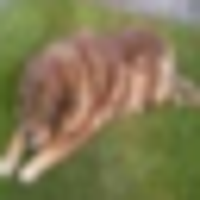

In [38]:
#keys = list(mixofexps_test.keys())
i = mixed_human_only_correct[2]
get_l2d_result_by_x(mixofexps_test, i, cifar_map)
PIL.Image.fromarray(dataset.data_test_loader.dataset.images[i]).resize((200,200))

### Staged learning
In all the methods in this section **two independent models** are trained:
* one for the AI agent, i.e., a multiclass classifier representing the probability of the AI predicting the correct class,
* a second for the human expert, i.e., a binary classifier representing the probability of the human being correct.

#### **Confidence Score**
*Maithra Raghu, Katy Blumer, Greg S Corrado, Jon M. Kleinberg, Ziad Obermeyer, and Sendhil Mullainathan. 2019. The Algorithmic Automation Problem: Prediction, Triage, and Human Effort. https://arxiv.org/abs/1903.12220.*

In this method, **two independent models** are trained:
* one for the AI agent, i.e., a multiclass classifier representing the probability of the AI predicting the correct class,
* a second for the human expert, i.e., a binary classifier representing the probability of the human being correct.

Algorithm:
1. Train the classifier $f_M$ using the cross entropy loss on all the data $X_{train}$.
2. Train a second model $f_H$ using the cross entropy loss to predict if the human is correct or not on all the data $X_{train}$.
3. At test time, the rejection score for each instance $i$ is computed as $R_{test}[i] = f_H(X_{test})[i,1]-Y_{test}[i]$. If $R_{test}[i]>0$, then set $Ρ_{test}[i]=\rho(X_{test}[i])=1$ and defer to the human expert.

In [39]:
conf, conf_test, conf_def_metrics, conf_clf_metrics, conf_coverage_metrics = get_l2d_results_and_metrics('SelectivePrediction',
    load_model_trained_cifar, 10, dataset, device, 100, optimizer, scheduler, 0.001, model_path)
#filehandler = open(model_folder+'conf_wideres', 'wb')
#pickle.dump(conf, filehandler)
#filehandler.close()

Computing L2D algorithm with method:  SelectivePrediction
Initializing the neural network model(s)
Initializing the L2D algorithm
Fitting the model


100%|██████████| 100/100 [05:30<00:00,  3.31s/it]


Computing predictions on the test set and corresponding metrics


In [44]:
conf = pickle.load(open(model_folder+'conf_wideres', 'rb'))
conf_test, conf_def_metrics, conf_clf_metrics, conf_coverage_metrics = loaded_l2d_results_and_metrics(conf, dataset)

In [45]:
conf_def_metrics

{'classifier_all_acc': 0.931,
 'human_all_acc': 0.9595,
 'coverage': 0.7204999999999999,
 'classifier_nondeferred_acc': 0.9944482997918113,
 'human_deferred_acc': 0.9194991055456172,
 'system_acc': 0.9735}

In [46]:
conf_human_only_correct, conf_both_correct, conf_ai_only_correct, conf_both_wrong = get_deferred_indices(conf_test)

defers :  1
labels :  automobile
max_probs :  0.64192784
hum_preds :  automobile
preds :  truck
rej_score :  0.3580721616744995


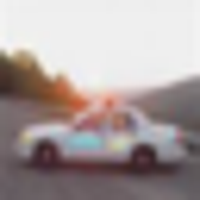

In [47]:
i = conf_human_only_correct[0]
get_l2d_result_by_x(conf_test, i, cifar_map)
PIL.Image.fromarray(dataset.data_test_loader.dataset.images[i]).resize((200,200))

<BarContainer object of 10 artists>

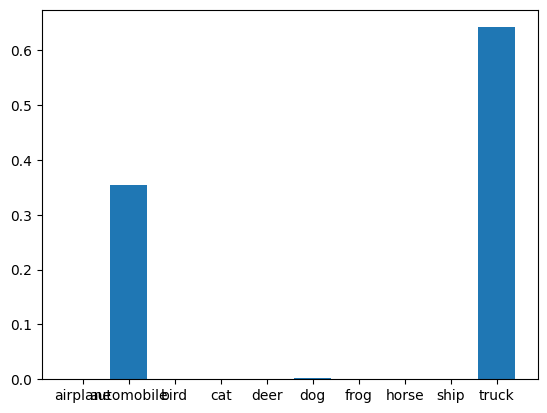

In [48]:
plt.bar(cifar_map.values(), conf_test['class_probs'][i])

#### **Differentiable Triage**
*Nastaran Okati, Abir De, and Manuel Rodriguez. 2021. Differentiable Learning Under Triage. In Advances in Neural Information Processing Systems, M. Ranzato, A. Beygelzimer, Y. Dauphin, P.S. Liang, and J. Wortman Vaughan (Eds.), Vol. 34. Curran Associates, Inc., 9140–9151. https://proceedings.neurips.cc/paper/2021/file/4c4c937b67cc8d785cea1e42ccea185c-Paper.pdf*

Algorithm:
1. Fine tune an optional weight hyperparameter $w\in\{0,1\}$, which represents a weight for points that are deferred so that classifier trains less on them ($w=0$ by default).
2. At train time:
  * For each epoch first fit the classifier only on those points where the classifier *weighted* loss is lower than human loss. In practice, when choosing the samples to defer, two strategies are possible: either one first check whether the model is correct (then the rejector $\rho_{train}$ is 1 and the *loss weight* is $w$ only if the human is correct and the model is wrong, otherwise  $\rho_{train}=0$ and $w=1$) or one first check if the human is correct (then the rejector is 1 and the weight is $w$ if the human is correct and otherwise $\rho_{train}=0$ and $w=1$). Hence, the classifier loss is computed as a *weighted* cross-entropy loss.
  * For each epoch select the samples to be deferred as in the previous point, then train the rejector by optimizing the cross-entropy loss on the points where the human is correct.
3. At test time, the samples are deferred to the human whenever based on the triage policy found at training time.




In [49]:
%timeit
dt, dt_test, dt_def_metrics, dt_clf_metrics, dt_coverage_metrics = get_l2d_results_and_metrics('DifferentiableTriage',
    load_model_trained_cifar, 10, dataset, device, 100, optimizer, scheduler, 0.001, model_path)
#filehandler = open(model_folder+'dt_wideres', 'wb')
#pickle.dump(dt, filehandler)
#filehandler.close()

Computing L2D algorithm with method:  DifferentiableTriage
Initializing the neural network model(s)
Initializing the L2D algorithm
Fitting the model


100%|██████████| 100/100 [05:38<00:00,  3.38s/it]

100%|██████████| 100/100 [05:38<00:00,  3.39s/it]

100%|██████████| 100/100 [10:35<00:00,  6.36s/it]


Computing predictions on the test set and corresponding metrics


In [56]:
dt = pickle.load(open(model_folder+'dt_wideres', 'rb'))
dt_test, dt_def_metrics, dt_clf_metrics, dt_coverage_metrics = loaded_l2d_results_and_metrics(dt, dataset)

In [57]:
dt_def_metrics

{'classifier_all_acc': 0.9,
 'human_all_acc': 0.9595,
 'coverage': 0.01749999999999996,
 'classifier_nondeferred_acc': 0.8571428571428571,
 'human_deferred_acc': 0.9587786259541985,
 'system_acc': 0.957}

In [58]:
dt_human_only_correct, dt_both_correct, dt_ai_only_correct, dt_both_wrong = get_deferred_indices(dt_test)

defers :  1
labels :  frog
hum_preds :  frog
preds :  airplane
rej_score :  0.66639066


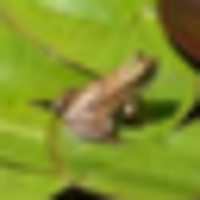

In [59]:
i = dt_human_only_correct[10]
get_l2d_result_by_x(dt_test, i, cifar_map)
PIL.Image.fromarray(dataset.data_test_loader.dataset.images[i]).resize((200,200))

<BarContainer object of 10 artists>

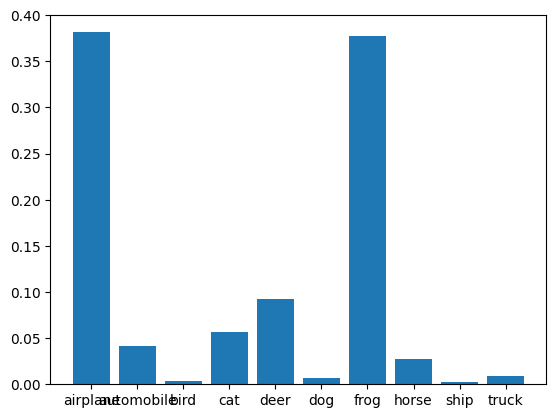

In [60]:
plt.bar(cifar_map.values(), dt_test['class_probs'][i])

### Joint learning
All the methods in this section share the same structure:
* At **training time** the classifier and rejector are trained jointly by minimizing a certain system loss over the augmented label space $Y∪\{∅\}$, where $∅$ correspond to the action of deferral. The proposed methods vary depending on how the **system loss** is defined.
* At **test time**, for a given sample $i$:
  * compute the softmax activation over the augmented label space but compute  the classifier prediction $Y_{test}[i]$ as the maximum over the first $K$ classes only;
  * compute the deferral score as the difference between the predicted probability for class $∅$ and that of the classifier prediction, that is, $r_{test}[i]=\hat{Y}_{test}[i,K+1]-Y_{test}[i]$;
  * binarize the deferral score according to: $\rho_{test}[i]=1$ if $r_{test}[i]≥t_r$, where the rejection threshold $t_r$ is set to 0 if not differently optimized (e.g., in the *realizable surrogate loss* method).

#### **Cross-Entropy Surrogate Loss**
*Hussein Mozannar and David Sontag. 2020. Consistent Estimators for Learning to Defer to an Expert. In Proceedings of the 37th International Conference on Machine Learning (Proceedings of Machine Learning Research, Vol. 119), Hal Daumé III and Aarti Singh (Eds.). PMLR, 7076–7087. https://dl.acm.org/doi/10.5555/3524938.3525594*

Algorithm (differences with the general framework for joint learning):
1. Fit the paramether $\alpha$ encourage or hinder the action of deferral.
2. For each training sample $i$, the system loss is given by  $\mathscr{L}=\frac{1}{n_{train}}\sum_i\ell_M[i]\cdot w[i]+\ell_H[i]\cdot \rho_{train}[i]$, where:
  * human loss: $\ell_H[i]=-\log_2(\hat{Y}_{train}[i,K+1])$;
  * classifier loss:  $\ell_M[i]=-\log_2 (\hat{Y}[i,Y_{train}^*[i]])$;
  * prediction probability of the classifier: $\hat{Y}_{train}[i]=σ(f(X_{train}[i,1:K])$, with $\sigma(\cdot)$ denoting the softmax function;
  * rejector?: $\rho_{train}[i]=\mathbb{I}_{H_{train}[i]=Y_{train}^*[i]}$;
  * wighting parameter: $w[i]=\alpha⋅\rho_{train}[i]+(1-\rho_{train}[i])$;



**NOTE**: This method is Fisher-consistent only for $\alpha=1$.

In [62]:
lce, lce_test, lce_def_metrics, lce_clf_metrics, lce_coverage_metrics = get_l2d_results_and_metrics('CrossEntropy',
    load_model_trained_cifar, 10, dataset, device, 100, optimizer, scheduler, 0.001,model_path)
#filehandler = open(model_folder+'lce_wideres', 'wb')
#pickle.dump(lce, filehandler)
#filehandler.close()

Computing L2D algorithm with method:  CrossEntropy
Initializing the neural network model(s)
Initializing the L2D algorithm
Fitting the model


100%|██████████| 100/100 [06:36<00:00,  3.96s/it]


Computing predictions on the test set and corresponding metrics


In [68]:
lce = pickle.load(open(model_folder+'lce_wideres', 'rb'))
lce_test, lce_def_metrics, lce_clf_metrics, lce_coverage_metrics = loaded_l2d_results_and_metrics(lce, dataset)

In [69]:
lce_def_metrics

{'classifier_all_acc': 0.929,
 'human_all_acc': 0.9595,
 'coverage': 0.476,
 'classifier_nondeferred_acc': 0.9968487394957983,
 'human_deferred_acc': 0.9437022900763359,
 'system_acc': 0.969}

In [70]:
lce_human_only_correct, lce_both_correct, lce_ai_only_correct, lce_both_wrong = get_deferred_indices(lce_test)

defers :  1
labels :  deer
hum_preds :  deer
preds :  horse
rej_score :  0.4846697300672531


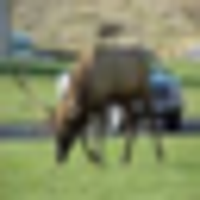

In [71]:
i = lce_human_only_correct[2]
get_l2d_result_by_x(lce_test, i, cifar_map)
PIL.Image.fromarray(dataset.data_test_loader.dataset.images[i]).resize((200,200))

<BarContainer object of 10 artists>

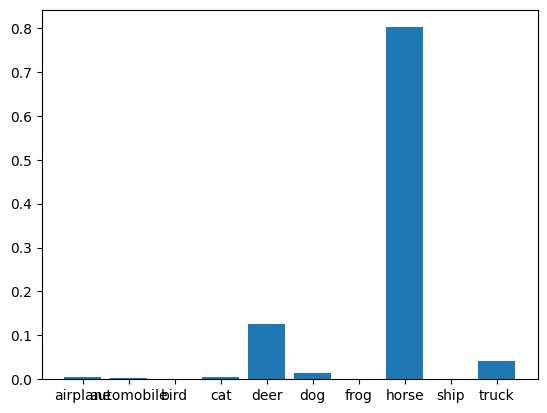

In [72]:
plt.bar(cifar_map.values(), dt_test['class_probs'][i])

#### **OvA Surrogate Loss**
*Rajeev Verma and Eric Nalisnick. 2022. Calibrated Learning to Defer with One-vs-All Classifiers. In Proceedings of the 39th International Conference on Machine Learning (Proceedings of Machine Learning Research, Vol. 162), Kamalika Chaudhuri, Stefanie Jegelka, Le Song, Csaba Szepesvari, Gang Niu, and Sivan Sabato (Eds.). PMLR, 22184–22202. https://proceedings.mlr.press/v162/verma22c.html*

Algorithm (differences with the general framework of joint learning):
1. The **system loss** is given by $\mathscr{L}=\frac{1}{n}\sum_i(\ell_1[i]+\ell_2[i]+\ell_3[i]+\ell_5[i])$, where all loss components are logistic losses:
  * rejector?: $\rho_{train}[i]=\mathbb{I}_{H_{train}[i]=Y_{train}^*[i]}$;
  * $\ell_1[i]=\log_2(1+e^{-\hat{Y}_{train}[i,Y_{train}^*]})$;
  * $\ell_2[i]=\sum_{y'\in\{1,\ldots,K\},y'\neq Y_{train}^*[i]}\log_2(1+e^{\hat{Y}_{train}[i,y']})$;
  * $\ell_3[i]=\log_2(1+e^{\hat{Y}_{train}[i,K+1]})$;
  * $\ell_5[i]= \rho_{train}[i](\log_2(1+e^{-\hat{Y}_{train}[i,K+1]})-\ell_3[i])$.

  **NOTE**: This method is Fisher-consistent AND calibrated.

In [74]:
ova, ova_test, ova_def_metrics, ova_clf_metrics, ova_coverage_metrics = get_l2d_results_and_metrics('OneVsAll',
    load_model_trained_cifar, 10, dataset, device, 100, optimizer, scheduler, 0.001, model_path)
#filehandler = open(model_folder+'ova_wideres', 'wb')
#pickle.dump(ova, filehandler)
#filehandler.close()

Computing L2D algorithm with method:  OneVsAll
Initializing the neural network model(s)
Initializing the L2D algorithm
Fitting the model


100%|██████████| 100/100 [06:25<00:00,  3.85s/it]


Computing predictions on the test set and corresponding metrics
